<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-NAO/blob/main/3_Model/NN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides severeal neural netwrok architectures to improve the prediction skill of the North Atlatnic Oscillation Index (NAO) on a daily basis. The architectures span from simple neural networks to a bit more complex neural networks with one or two LSTM cells.

At the end of the notebook, a summary is provided.

# Libraries and define functions

In [89]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [90]:
# Function to create input-output pairs for time series prediction
def create_input_output_pairs(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# edit function create_input_output_pairs
def create_input_output_pairs_X(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data[0]) - window_size - forecast_horizon + 1):
        X.append(data[:,i:i + window_size])
        y.append(data[0][i + window_size:i + window_size + forecast_horizon])
    X = np.stack(X,axis=0)
    y = np.stack(y)
    return X,y

# normalize the data
def normalize(data):
  """
  Returns normailzed data, MIN,MAX
  """
  MIN = min(data)
  MAX = max(data)
  normalized_data = (data - MIN)/(MAX-MIN)
  return normalized_data,MIN,MAX

def denormalize(normalized_data,MIN,MAX):
  """
  uses MIN and MAX of the original data to denormalize the normalized data
  """
  denormalized_data = normalized_data*(MAX-MIN) + MIN
  return denormalized_data


def phase_check(y_test,y_pred):
  """
  Args:
    y_test
    y_pred

  Returns: phase agreement of the two time series in percentage
  """

  #check for phases in y_test and y_pred:
  y_test_phases = np.zeros(len(y_test))
  y_pred_phases = np.zeros(len(y_pred))
  negative_test = np.where(y_test <-1)[0]# currently everything between -1 and 1 is set to neutral (might have to rethink tis interval)
  negative_pred = np.where(y_pred <-1)[0]
  positive_test = np.where(y_test >1)[0]
  positive_pred = np.where(y_pred >1)[0]
  y_test_phases[negative_test] = -1
  y_pred_phases[negative_pred] = -1
  y_test_phases[positive_test] = 1
  y_pred_phases[positive_pred] = 1
  counter = np.sum(y_test_phases==y_pred_phases)
  phase_percent = 100/len(y_test) * counter
  return phase_percent


def rolling_forecast(historical, forecast_range, model, model_prediction=1):
  """
  this function is used by the function predict_rolling_test
  it takes one sample of the test dataset and calculates the rolling forecast depending on the forecast_range
  """
  hist = historical
  predictions = []
  for _ in range(forecast_range):

    pred = model.predict(hist) # predicts the next value based on the historical (e.g. last 30 days as window size)
    hist = np.concatenate((hist[:,model_prediction:,:],pred[np.newaxis,:]),axis=1) # deletes the first (oldest) value of historical and adds the predicted on at the end - for a different model the shape has to be edited; the historical data is updated now and ready for the next prediction

    predictions.append(np.squeeze(pred)) # the predicted value is added to the prediction list
  predictions = np.array(predictions)

  return predictions

def predict_rolling_test(X_test, y_test, forecast_range, model):
  """
  uses the function rolling_forecast
  X_test, y_test have to be in the right shape, suitable for the model e.g. LSTM: 5000,30,1 and 5000,10 for X_test and y_test, respectively
  forecast range would be 10 in this example from above

  funtion iterates through test dataset and predicts based on the window size (here 30) one next value
  this value added to the window while the first value is deleted -> the window for the next prediction is therefore updated
  The iterations of this process depend on the forecast_range (e.g. 10)

  This function gives the frame of the forecast
  The function rolling_forecast calculates the 10 iterations.
  """
  number_pred = len(X_test[:,1]) - forecast_range - len(X_test[0])

  Y = np.squeeze(y_test)

  predictions = []
  true_predictions = []
  # iterate through the test dataset, if forecast_range would be one it would be  normal prediction in two for-loops
  for i in range(number_pred):
    predictions.append(rolling_forecast(X_test[i][np.newaxis,:],forecast_range,model))
    true_predictions.append(Y[i:i+forecast_range])

  return predictions, true_predictions


def model_forecast(model, tf_dataset, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Create batches of windows
    tf_dataset = tf_dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(tf_dataset)

    return forecast

# Callback function:
class LossLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_filename='best_model.h7'):
        super(LossLoggerCallback, self).__init__()
        self.model_filename = model_filename
        self.best_val_loss = float('inf')
        self.hist_train = []
        self.hist_test = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.hist_train.append(train_loss)
        self.hist_test.append(val_loss)

        # Save the model if the current validation loss is lower than the previous best
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            #self.model.save(self.model_filename)
            #self.model.save("/content/drive/My Drive/Colab Notebooks/fishmarkt/model_saving.h6")
            print(f'Saving the best model to {self.model_filename}')


# Load Daily Data

- load daily data
- normalize it

In [91]:
# load daily dataset for period: 1950-01-01 - 2024-05-12
path_NAO_index_daily = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_DAILY.csv"

NAO_df = pd.read_csv(path_NAO_index_daily,delimiter=',')

# Convert the 'date' column to datetime
NAO_df['date'] = pd.to_datetime(NAO_df['date'])
# Set the 'date' column as the index
NAO_df.set_index('date', inplace=True)

## Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_df['nao_index_daily'])

# Model
Several architectures are tried to predict the NAO:
- Simple NN
- More Complex NN
- Simple LSTM model
- LSTM with more hidden layers and dropout
- Conv + LSTM

Each model section has the same structure:
- choosing window size and forecast horizon
- create input-output pairs
- split them for training and testing
- optionally convert data into tensorflow datasets or reshape them to a model suitable format
- building model architecture
- compiling and training
- testing with visualizing and uncertainty measurements


## Simple Neural Network

## Window size = 24, forecast horizon = 1

In [14]:
# Create input-output pairs
window_size = 24
forecast_horizon = 1
X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# converting data to tensor flow dataset
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [15]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape = (None, window_size)),
    tf.keras.layers.Dense(forecast_horizon, activation='linear')  # Correct activation for regression
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# fit model on training data
history = model.fit(tf_train.batch(32), epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, None, 64)          1600      
                                                                 
 dense_3 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 1665 (6.50 KB)
Trainable params: 1665 (6.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
679/679 [==============================] - 3s 3ms/step - loss: 0.0062
Epoch 2/10
679/679 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 3/10
679/679 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 4/10
679/679 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 5/10
679/679 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 6/10
67

In [16]:
# predictions
y_pred = model.predict(X_test)

170/170 [==============================] - 0s 1ms/step


In [17]:
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

averaged MSE = 0.057900417614084224; phase ratio = 90.42004421518055


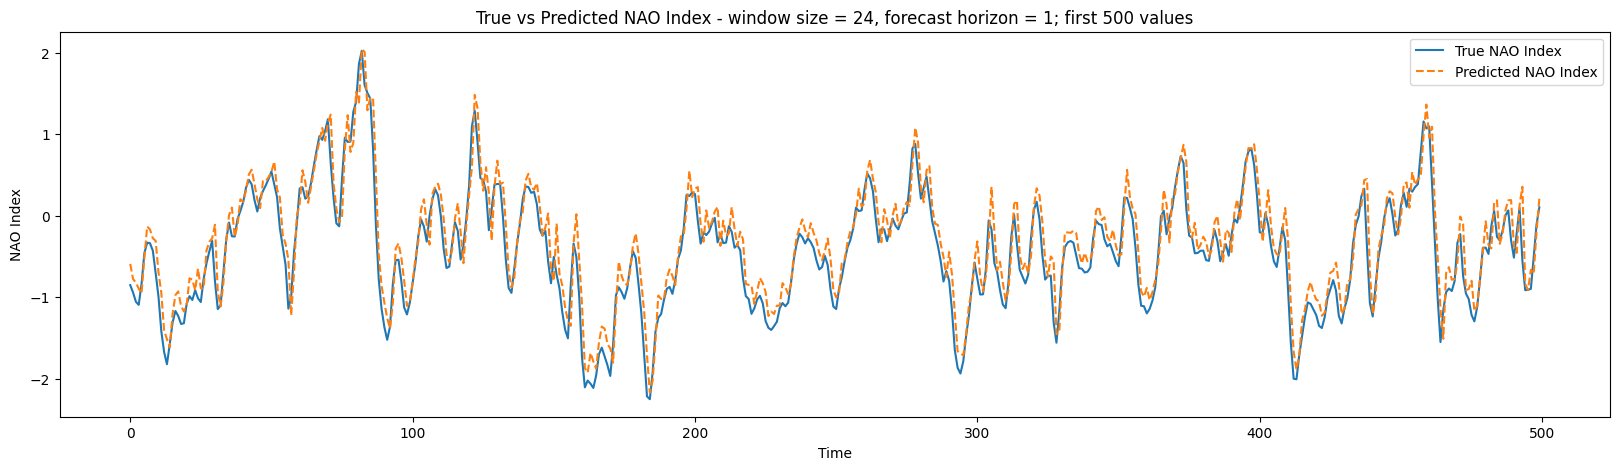

In [21]:
# Create time points for plotting
predicted_values = y_pred_denorm.flatten()[:500]
true_values = y_test_denorm.flatten()[:500]

time_points = np.arange(len(true_values))
plt.figure(figsize=(20,5))
plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index - window size = 24, forecast horizon = 1; first 500 values')
plt.legend()
plt.show()

## Window size = 48, forecast horizon = 10

In [22]:
# Create input-output pairs
window_size = 48
forecast_horizon = 10
X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# converting data to tensor flow dataset
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape = (None, window_size)),
    tf.keras.layers.Dense(forecast_horizon, activation='linear')  # Correct activation for regression
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# fit model on training data
history = model.fit(tf_train.batch(32), epochs=10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 64)          3136      
                                                                 
 dense_5 (Dense)             (None, None, 10)          650       
                                                                 
Total params: 3786 (14.79 KB)
Trainable params: 3786 (14.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
678/678 [==============================] - 4s 4ms/step - loss: 0.0221
Epoch 2/10
678/678 [==============================] - 2s 2ms/step - loss: 0.0147
Epoch 3/10
678/678 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 4/10
678/678 [==============================] - 2s 3ms/step - loss: 0.0138
Epoch 5/10
678/678 [==============================] - 2s 3ms/step - loss: 0.0136
Epoch 6/10


In [24]:
# predictions
y_pred = model.predict(X_test)

# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 0s 2ms/step
averaged MSE = 0.484182110410077; phase ratio = 54.860726803172845


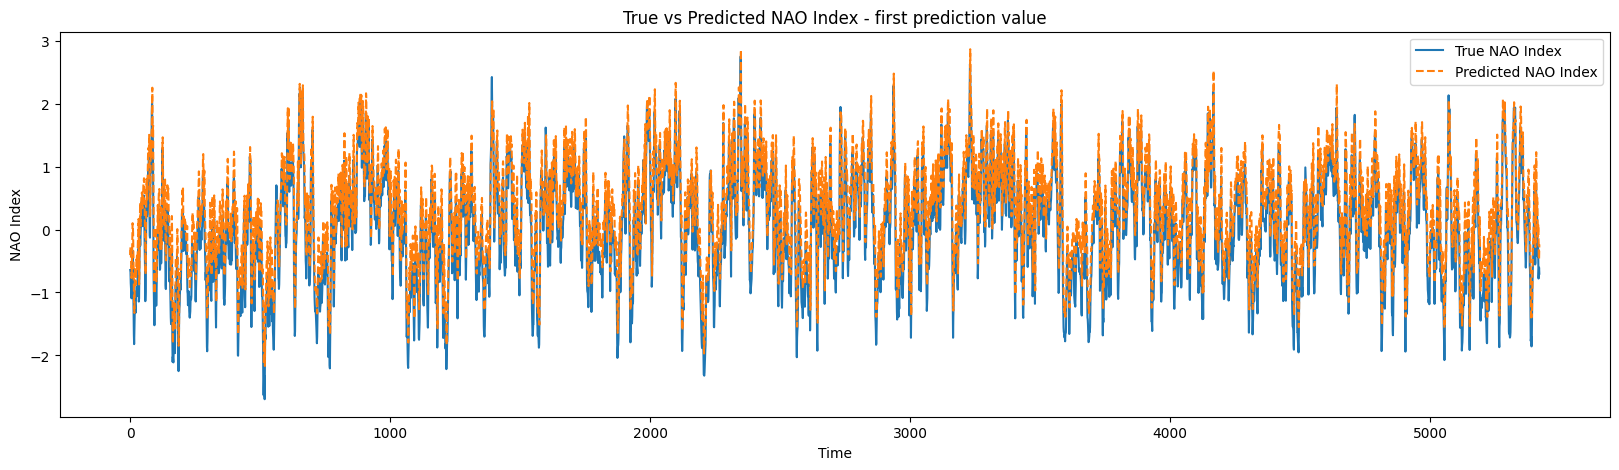

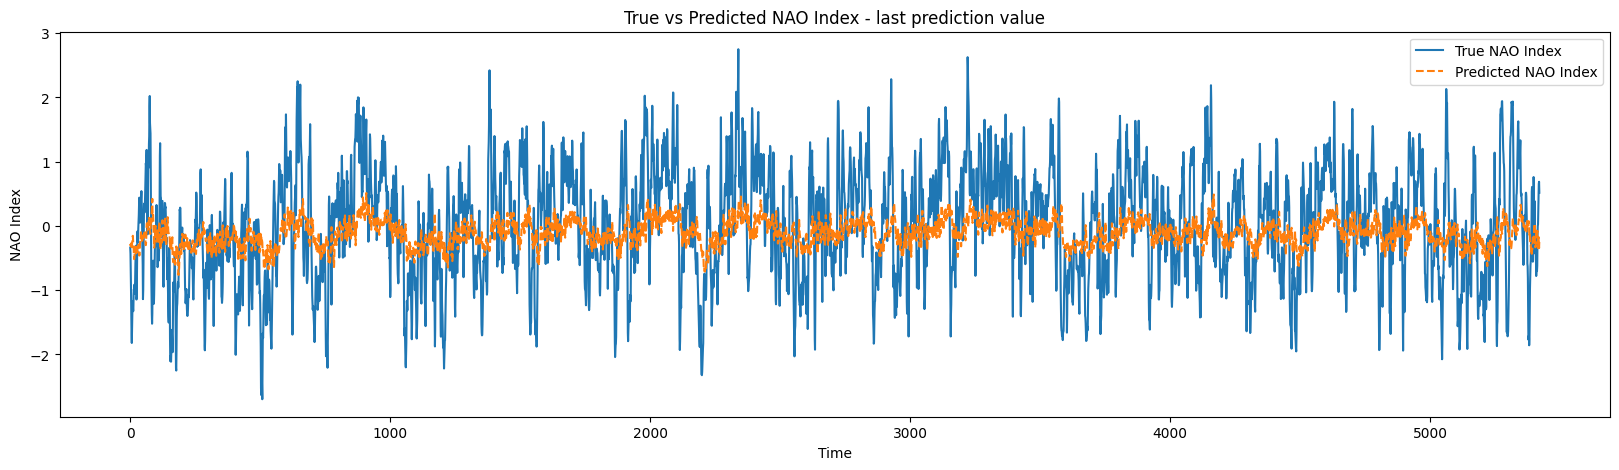

In [25]:
# plot
predicted_values = y_pred_denorm.flatten()[0::10]
true_values = y_test_denorm.flatten()[0::10]

time_points = np.arange(len(true_values))
plt.figure(figsize=(20,5))
plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index - first prediction value')
plt.legend()
plt.show()



predicted_values = y_pred_denorm.flatten()[9::10]
true_values = y_test_denorm.flatten()[9::10]

time_points = np.arange(len(true_values))
plt.figure(figsize=(20,5))
plt.plot(time_points, true_values, label='True NAO Index')
plt.plot(time_points, predicted_values, label='Predicted NAO Index', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('True vs Predicted NAO Index - last prediction value')
plt.legend()
plt.show()

Prediction skill for one or two days is very good, for higher forecast ranges the uncertainty strongly increases.

## More complex neural network
Hidden Layers: 3  
Neurons per Layer: 32, 32, 16  
More complex model does not imporve the performance.  
Option for dropout (0.2) downgrades the performance.

In [26]:
# Create input-output pairs
window_size = 48
forecast_horizon = 10
X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# converting data to tensor flow dataset
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))


In [27]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape = (None, window_size)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(forecast_horizon, activation='linear')  # Correct activation for regression
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# fit model on training data
history = model.fit(tf_train.batch(32), epochs=15)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, None, 32)          1568      
                                                                 
 dense_7 (Dense)             (None, None, 32)          1056      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense_8 (Dense)             (None, None, 16)          528       
                                                                 
 dense_9 (Dense)             (None, None, 10)          170       
                                                                 
Total params: 3322 (12.98 KB)
Trainable params: 3322 (12.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
678/678 [

In [28]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 0s 2ms/step
averaged MSE = 0.5122064970848326; phase ratio = 46.61501567976388


## Simple LSTM
One LSTM layer with 64 units  
One output dense layer  
With 10 Epochs: Slight improvement but training needs way more time!

In [31]:
# LSTM input layer needs structure: (batch_size, timesteps, features) -> modify train Data:

# Create input-output pairs
window_size = 48
forecast_horizon = 10

X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2 # with validation the results are getting worse
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]


In [32]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (window_size,1)),
    tf.keras.layers.Dense(units=forecast_horizon)
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


# fit model on training data
history = model.fit(X_train,y_train, epochs=10)#,validation_data=(X_val, y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 17546 (68.54 KB)
Trainable params: 17546 (68.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
678/678 [==============================] - 19s 26ms/step - loss: 0.0202
Epoch 2/10
678/678 [==============================] - 17s 26ms/step - loss: 0.0134
Epoch 3/10
678/678 [==============================] - 18s 26ms/step - loss: 0.0127
Epoch 4/10
678/678 [==============================] - 19s 28ms/step - loss: 0.0124
Epoch 5/10
678/678 [==============================] - 18s 26ms/step - loss: 0.0122

In [33]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 2s 9ms/step
MSE = 0.43322452433827335; phase ratio = 56.42870319129312


This model slightly imporves the predictions for medium range forecasts (10 days).

## LSTM with more hidden layers and option dropout
Performance is basically the same as for the simple LSTM

In [34]:
# Create input-output pairs
window_size = 48
forecast_horizon = 10

X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2 # with validation the results are getting worse
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]


In [36]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (window_size,1)),
    tf.keras.layers.Dense(units = 64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 32),
    tf.keras.layers.Dense(units=forecast_horizon, activation='linear')  # Correct activation for regression, , activation='linear'
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


# fit model on training data
history = model.fit(X_train,y_train, epochs=10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 23466 (91.66 KB)
Trainable params: 23466 (91.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
678/678

In [37]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 2s 10ms/step
averaged MSE = 0.44005465202710253; phase ratio = 56.88987271721084


## LSTM with Conv
Model only with Convolutional Layer is slightly worse than 1 LSTM layer but faster in training; longer training helps to improve the performance

Model with LSTM and Conv layer didn't improve the performance even with 10 epochs longer.

In [38]:
# Create input-output pairs
window_size = 48
forecast_horizon = 10

X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2 # with validation the results are getting worse
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]

In [42]:
# Converting data to TensorFlow datasets
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(units=forecast_horizon)  # Output layer
])

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model on training data
history = model.fit(tf_train, epochs=20)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 64)            0         
 D)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 10)                650       
                                                                 
Total params: 38090 (148.79 KB)
Trainable params: 38090 (148.79 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [41]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 2s 9ms/step
averaged MSE = 0.4526640534094076; phase ratio = 55.06364139457664


## 2 LSTM layers with 2 hidden layers
- LSTM 64  
- LSTM 64  
- Dense 32  
- Dense 32  
Performance was about the same but training needed much longer

In [ ]:
# Create input-output pairs
window_size = 48
forecast_horizon = 10

X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2 # with validation the results are getting worse
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]

# Converting data to TensorFlow datasets
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (window_size,1), return_sequences=True),
    tf.keras.layers.LSTM(units = 64),
    tf.keras.layers.Dense(units = 32),
    tf.keras.layers.Dense(units = 16),
    tf.keras.layers.Dense(units=forecast_horizon)  # Correct activation for regression, , activation='linear'
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


# fit model on training data
history = model.fit(tf_train, epochs=10)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 48, 64)            16896     
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 10)                170       
                                                                 
Total params: 52698 (205.85 KB)
Trainable params: 52698 (205.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
678/

In [ ]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

170/170 [==============================] - 6s 23ms/step
averaged MSE = 0.44163242989246404; phase ratio = 56.66851134477034


# Summary of model section and further steps:
Different model architectures such as Neural Network, LSTM and Conv were tried.  
The simple LSTM had the best performance for a window size of 48 and prediction of 10 days with MSE = 0.44 and phase ratio = 56.39%.  
Increased window size to 100 days and a hidden layer between LSTM and output did not increased the performance. Thus, the simple LSTM model is used for the next steps.

Next Steps:  
- provide external dataset such es ENSO (linear interpolated for daily values)
  - BUT: ENSO is just available from 1950 instead of 1870 - immense data loss  
- provide seasonal static information such as temp over Iceland or more abstract a cosine function depending on the day of the year.  
- try rolling forecast

## Simple LSTM with ENSO
The El Nino - Southern Oscillation Index has a monthly time resolution. To use it for a daily forecast it has to be interpolated (in this case linear).

In [56]:
# load ENSO Dataset
# load monthly Nino dataset for period: 1870-01 - 2024-12 (at the end nan)
path_Nino_index_monhtly = "https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/Nino_index.csv"
ENSO_df = pd.read_csv(path_Nino_index_monhtly,delimiter=',')
ENSO_df = ENSO_df[:-9] # the last 9 months are Nan

# Convert the 'Date' column to datetime
ENSO_df['Date'] = pd.to_datetime(ENSO_df['Date'])
# Set the 'date' column as the index
ENSO_df.set_index('Date',inplace=True)

# Resample to daily frequency
ENSO_df_daily = ENSO_df.resample('D').asfreq().interpolate(method='linear')

# slicing it to the same time length as daily NAO
ENSO_df_daily = ENSO_df_daily.loc['1950-01-01':'2024-03-01']

# putting it into NAO_df :
NAO_df['ENSO'] = ENSO_df_daily

# slice NAO_df to 2024-03-01 because ENSO is not availalbe to march
NAO_df = NAO_df.loc[:'2024-03-01']

NAO_df

,nao_index_daily,ENSO
date,,
1950-01-01,0.365000,-1.050000
1950-01-02,0.096000,-1.064516
1950-01-03,-0.416000,-1.079032
1950-01-04,-0.616000,-1.093548
1950-01-05,-0.261000,-1.108065
...,...,...
2024-02-26,1.073471,1.151034
2024-02-27,1.032663,1.138276
2024-02-28,1.224713,1.125517


Model:

With 48 days predicting 10 days the result isn't as good as for the model with just the NAO! It is slightly worse -> Seems like ENSO only adds noise :/

In [59]:
## Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_df['nao_index_daily'])
ENSO_normed,ENSO_min,ENSO_max = normalize(NAO_df['ENSO'])
DATA = np.array([NAO_normed,ENSO_normed])
# Create input-output pairs
window_size = 48
forecast_horizon = 10

X, y = create_input_output_pairs_X(DATA, window_size, forecast_horizon) # different function for external ime serie

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Converting data to TensorFlow datasets
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [60]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (2,window_size)),
    tf.keras.layers.Dense(units=forecast_horizon)  # Correct activation for regression, , activation='linear'
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# fit model on training data
history = model.fit(tf_train, epochs=20)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                28928     
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 29578 (115.54 KB)
Trainable params: 29578 (115.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
676/676 [==============================] - 5s 4ms/step - loss: 0.0227
Epoch 2/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0159
Epoch 3/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0150
Epoch 4/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0144
Epoch 5/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0141
Epoch 6

In [61]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

169/169 [==============================] - 1s 3ms/step
averaged MSE = 0.4981423317938134; phase ratio = 51.47031625670427


## Simple LSTM with static year information

Also does not improve the forecast ability.

In [62]:
# create seasonal static information cosine function for the year
# Calculate the day of the year
NAO_df['day_of_year'] = NAO_df.index.dayofyear

# Normalize the day of the year to a range of 0 to 2π
NAO_df['cos_day_of_year'] = np.cos(2 * np.pi * (NAO_df['day_of_year'] - 1) / 365.25)

NAO_df

<ipython-input-62-bf2f6ab9d61d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NAO_df['day_of_year'] = NAO_df.index.dayofyear
<ipython-input-62-bf2f6ab9d61d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NAO_df['cos_day_of_year'] = np.cos(2 * np.pi * (NAO_df['day_of_year'] - 1) / 365.25)


,nao_index_daily,ENSO,day_of_year,cos_day_of_year
date,,,,
1950-01-01,0.365000,-1.050000,1,1.000000
1950-01-02,0.096000,-1.064516,2,0.999852
1950-01-03,-0.416000,-1.079032,3,0.999408
1950-01-04,-0.616000,-1.093548,4,0.998669
1950-01-05,-0.261000,-1.108065,5,0.997634
...,...,...,...,...
2024-02-26,1.073471,1.151034,57,0.570784
2024-02-27,1.032663,1.138276,58,0.556576
2024-02-28,1.224713,1.125517,59,0.542202


In [63]:
## Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_df['nao_index_daily'])
# Cosine of day of the year is already normed
DATA = np.array([NAO_normed,NAO_df['cos_day_of_year']])
# Create input-output pairs
window_size = 48  # Use past 12 months for prediction
forecast_horizon = 10  # Predict next 6 months

X, y = create_input_output_pairs_X(DATA, window_size, forecast_horizon)

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Converting data to TensorFlow datasets
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [64]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (2,window_size)),
    tf.keras.layers.Dense(units=forecast_horizon)
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# fit model on training data
history = model.fit(tf_train, epochs=20)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                28928     
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
Total params: 29578 (115.54 KB)
Trainable params: 29578 (115.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
676/676 [==============================] - 5s 4ms/step - loss: 0.0245
Epoch 2/20
676/676 [==============================] - 3s 5ms/step - loss: 0.0165
Epoch 3/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0158
Epoch 4/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0153
Epoch 5/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0150
Epoch 

In [65]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

169/169 [==============================] - 1s 2ms/step
averaged MSE = 0.46838152224614366; phase ratio = 50.157203624930645


## Simple LSTM with ENSO and static year information

Also doesn't imporve the forecast.

In [66]:
## Normalize the data
NAO_normed,NAO_min,NAO_max = normalize(NAO_df['nao_index_daily'])
ENSO_normed,ENSO_min,ENSO_max = normalize(NAO_df['ENSO'])
DATA = np.array([NAO_normed,ENSO_normed,NAO_df['cos_day_of_year']])
# Create input-output pairs
window_size = 48  # Use past 12 months for prediction
forecast_horizon = 10  # Predict next 6 months

X, y = create_input_output_pairs_X(DATA, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
#X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Converting data to TensorFlow datasets
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [67]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (3,window_size)),
    tf.keras.layers.Dense(units=forecast_horizon)  # Correct activation for regression, , activation='linear'
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


# fit model on training data
history = model.fit(tf_train, epochs=20)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                28928     
                                                                 
 dense_22 (Dense)            (None, 10)                650       
                                                                 
Total params: 29578 (115.54 KB)
Trainable params: 29578 (115.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
676/676 [==============================] - 5s 4ms/step - loss: 0.0259
Epoch 2/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0181
Epoch 3/20
676/676 [==============================] - 4s 5ms/step - loss: 0.0170
Epoch 4/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0163
Epoch 5/20
676/676 [==============================] - 3s 4ms/step - loss: 0.0158
Epoch 

In [ ]:
# predictions
y_pred = model.predict(X_test)
# denormalize predictions and test data
y_test_denorm = denormalize(y_test,NAO_min,NAO_max)
y_pred_denorm = denormalize(y_pred,NAO_min,NAO_max)

# evaluate predictions:
MSE = mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
phase_ratio = phase_check(y_test_denorm, y_pred_denorm)

print("averaged MSE = {}; phase ratio = {}".format(MSE,phase_ratio))

169/169 [==============================] - 1s 3ms/step
averaged MSE = 0.49690800345169467; phase ratio = 48.99204734603292


## Rolling Forecast
Because the medium range forecast (about 10 days) were not very successful yet, a rolling forecast approach is tried in the following section. For that purpose a simple LSTM model is used which predicts one day with a windows size of 30 days. The rolling forecast predicts 10 days.

The forecast needed very long (almost 2 hours) to predict 5500 sets (each 10 days). At the end the MSE = 0.5191 and the Ratio of correct predicted phases = 77.16%. Therefore, the MSE slightly increased 0.0349 but the correct predicted phases improved from 54.9% (simple forecast) to 77.2% (rolling forecast). And again with a longer forecast range the uncertainty increases.


In [92]:
# Create input-output pairs
window_size = 30
forecast_horizon = 1

X, y = create_input_output_pairs(NAO_normed, window_size, forecast_horizon)

# Reshape X to have 3 dimensions: (samples, timesteps, features)
X = np.expand_dims(X, axis=-1)  # Add a new axis for features

# Split the data into training and testing sets based on time
train_ratio, validation_ratio, test_ratio = 0.8, 0.0, 0.2 # with validation the results are getting worse
X_train, X_val, X_test = X[:int(len(X)*train_ratio)], X[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], X[int(len(X)*train_ratio + len(X)*validation_ratio):]
y_train, y_val, y_test = y[:int(len(X)*train_ratio)], y[int(len(X)*train_ratio):int(len(X)*train_ratio + len(X)*validation_ratio)], y[int(len(X)*train_ratio + len(X)*validation_ratio):]


In [93]:
#specify model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape = (window_size,1)),
    tf.keras.layers.Dense(units=forecast_horizon)
])
#compile model and get summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


# fit model on training data
history = model.fit(X_train,y_train, epochs=10)#,validation_data=(X_val, y_val))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                16896     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
679/679 [==============================] - 23s 26ms/step - loss: 0.0127
Epoch 2/10
679/679 [==============================] - 13s 19ms/step - loss: 0.0026
Epoch 3/10
679/679 [==============================] - 12s 17ms/step - loss: 0.0017
Epoch 4/10
679/679 [==============================] - 12s 17ms/step - loss: 0.0013
Epoch 5/10
679/679 [==============================] - 13s 19ms/step - loss: 0.001

In [117]:
def rolling_forecast(historical, forecast_range, model, model_prediction=1):
  hist = historical
  predictions = []
  for _ in range(forecast_range):

    pred = model.predict(hist)
    hist = np.concatenate((hist[:,model_prediction:,:],pred[np.newaxis,:]),axis=1)

    predictions.append(np.squeeze(pred))
  predictions = np.array(predictions)

  return predictions

def predict_rolling_test(X_test, y_test, forecast_range, model):
  number_pred = len(X_test[:,1]) - forecast_range - len(X_test[0])

  Y = np.squeeze(y_test)

  predictions = []
  true_predictions = []
  for i in range(number_pred):
    predictions.append(rolling_forecast(X_test[i][np.newaxis,:],forecast_range,model))
    true_predictions.append(Y[i:i+forecast_range])

  return predictions, true_predictions

In [118]:
# predict - !!!!!!!only works if elm model is trained with predicting one value!!!!!

forecast_range = 10
# y_pred, y_test = predict_rolling_test(X_test_flat, y_test_flat,forecast_range, elm)
y_pred, y_test = predict_rolling_test(X_test, y_test,forecast_range, model)

# denormalize
y_test_flat = np.array(y_test)
y_pred_flat = np.array(y_pred)

y_test_actual = denormalize(y_test_flat,NAO_min,NAO_max)
y_pred_actual = denormalize(y_pred_flat,NAO_min,NAO_max)


# measures such as MSE and phase
# Calculate the mean squared error
mse = mean_squared_error(y_test_actual.flatten(), y_pred_actual.flatten())
phase_ratio = phase_check(y_test_actual.flatten(),y_pred_actual.flatten())
print(f'Mean Squared Error: {mse}')
print("Ratio of correct predicted phases = ", phase_ratio)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1/1 [==============================] - 0s 34ms/step
Mean Squared Error: 0.5190541789803871
Ratio of correct predicted phases =  77.16354186003342


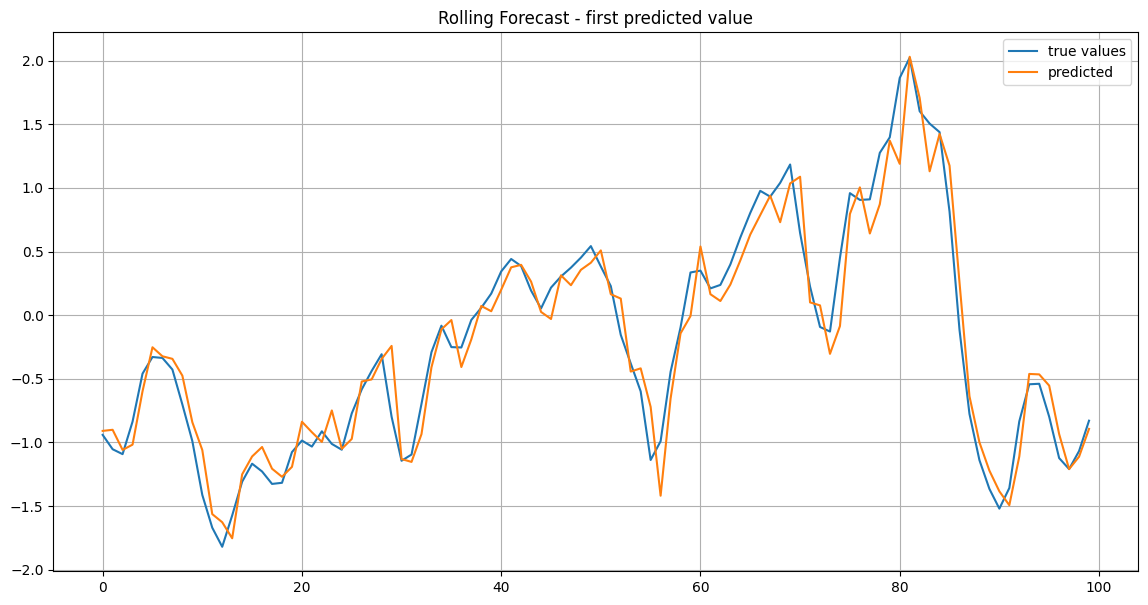

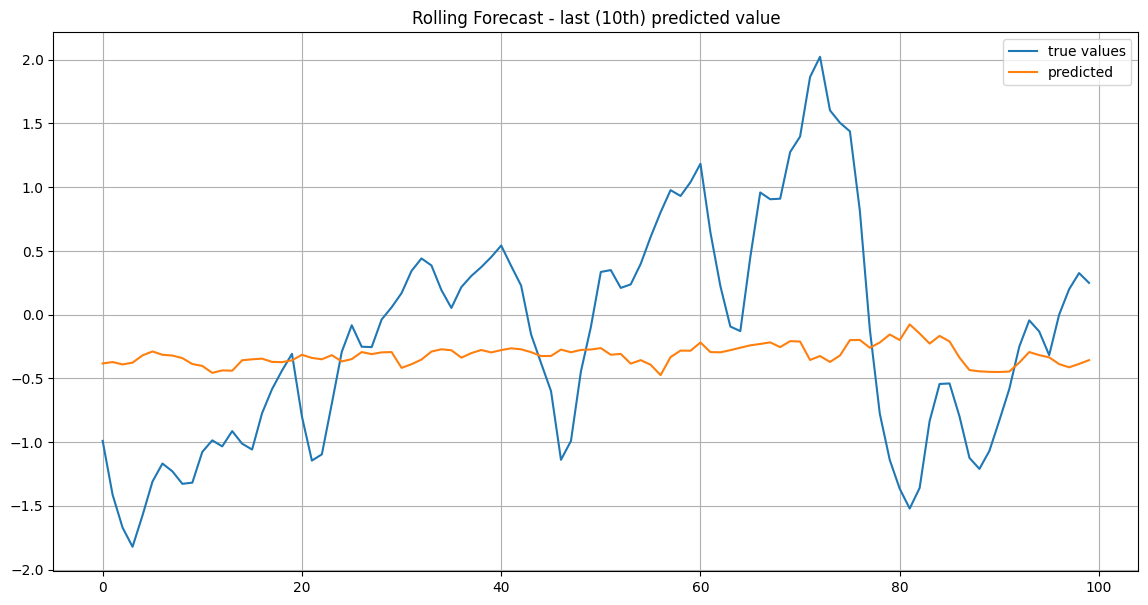

In [133]:
L1 = 0
L2 = 100
I = 0

plt.figure(figsize=(14,7))
plt.plot(y_test_actual[L1:L2,I],label='true values')
plt.plot(y_pred_actual[L1:L2,I],label='predicted')
plt.title("Rolling Forecast - first predicted value")
plt.legend()
plt.grid()
plt.show()

I = 9
plt.figure(figsize=(14,7))
plt.plot(y_test_actual[L1:L2,I],label='true values')
plt.plot(y_pred_actual[L1:L2,I],label='predicted')
plt.title("Rolling Forecast - last (10th) predicted value")
plt.legend()
plt.grid()
plt.show()

# Summary
Through all models in this notebook, the simple LSTM model has the best result regarding the medium range forecast (10 days). Different architectures were slightly worse. To improve the forecast, an LSTM model for a 1-day-prediction was trained and used for a rolling forecast. The calculation time was very long. At the end the MSE was slightly worse but the phase ratio increased very strong.